# Decision trees
## for PTV margin in single isocenter multiple mets SRS

In this notebook is presented the architecture of a decision tree to classify PTV margins for radiosurgery of multiple mets in three classes (0.5, 1 or 2 mm).

In [1]:
from platform import python_version

# Part of the PhD project based on artificial intelligence on radiosurgery for multiple mets
# The information extracted from this notebook has to be notified to authors. 

__author__ = "José Alejandro Rojas López"
__institution__ = "Universidad Nacional de Córdoba"
__copyright__ = "Copyright (C) 2022 Alejandro Rojas"
__license__ = "Public Domain"
__version__ = "1.0"
__email__ = "alexrojas@ciencias.unam.mx"

print(python_version())

3.9.5


In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

# Configure warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

In [5]:
#Import dataset
datos = pd.read_excel('Dataset1.xlsx')

datos.head(1)

,Total Mets,Volume [cc],Dist2Iso [mm],PTV-margin [mm]
0,5,1.031,60,2


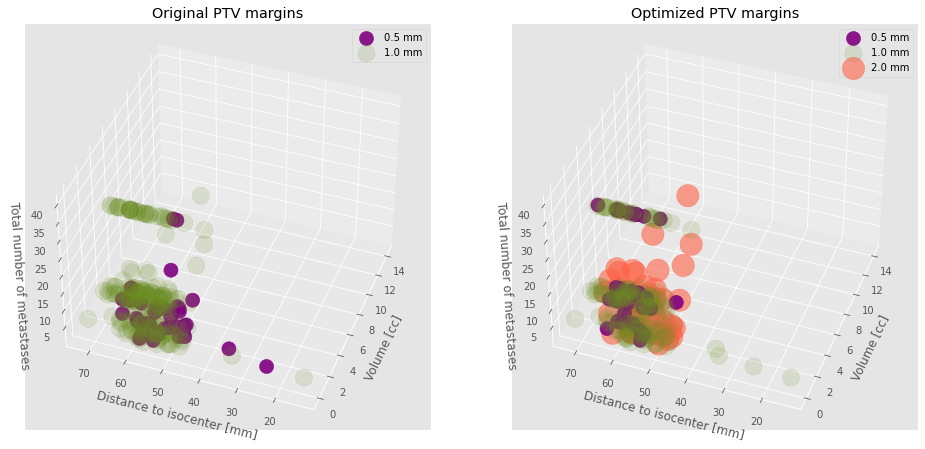

In [6]:
#Import dataset aux
d1 = pd.read_excel('d1.xlsx')
d2 = pd.read_excel('d2.xlsx')
d3 = pd.read_excel('d3.xlsx')
d11 = pd.read_excel('d11.xlsx')
d22 = pd.read_excel('d22.xlsx')
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(d11['Volume [cc]'].tolist(), d11['Dist2Iso [mm]'].tolist(), d11['Total Mets'].tolist(), c='purple', alpha=0.9, s=200, label ='0.5 mm')
ax.scatter(d22['Volume [cc]'].tolist(), d22['Dist2Iso [mm]'].tolist(), d22['Total Mets'].tolist(), c='olivedrab', alpha=0.15, s=300, label ='1.0 mm')
ax.set_xlabel('Volume [cc]', rotation=150)
ax.set_ylabel('Distance to isocenter [mm]')
ax.set_zlabel('Total number of metastases', rotation=90)
ax.set_title('Original PTV margins')
ax.view_init(40, 200)
ax.legend()


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(d1['Volume [cc]'].tolist(), d1['Dist2Iso [mm]'].tolist(), d1['Total Mets'].tolist(), c='purple', alpha=0.9, s=200, label ='0.5 mm')
ax.scatter(d2['Volume [cc]'].tolist(), d2['Dist2Iso [mm]'].tolist(), d2['Total Mets'].tolist(), c='olivedrab', alpha=0.15, s=300, label ='1.0 mm')
ax.scatter(d3['Volume [cc]'].tolist(), d3['Dist2Iso [mm]'].tolist(), d3['Total Mets'].tolist(), c='tomato', alpha=0.6, s=500, label ='2.0 mm')
ax.set_xlabel('Volume [cc]', rotation=150)
ax.set_ylabel('Distance to isocenter [mm]')
ax.set_zlabel('Total number of metastases', rotation=10)
ax.set_title('Optimized PTV margins')
ax.view_init(40, 200)
ax.legend()
plt.savefig('ptv.tif', dpi=200, facecolor='white')

In [7]:
# Train and test
# ------------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'PTV-margin [mm]'),
                                        datos['PTV-margin [mm]'],
                                        random_state = 123
                                    )

In [8]:
def encode_target(df, target_column):
    """Add column to df with integers for the target.

    Args
    ----
    df -- pandas DataFrame.
    target_column -- column to map to int, producing
                     new Target column.

    Returns
    -------
    df_mod -- modified DataFrame.
    targets -- list of target names.
    """
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets+2)}
    df_mod["Target"] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

In [9]:
df, target = encode_target(datos, "PTV-margin [mm]")

features = list(df.columns[:3])

In [10]:
y = df["Target"]
X = df[features]

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        random_state = 123
                                    )

dt = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy', min_samples_split=10, min_samples_leaf=2, splitter="best", random_state=123, class_weight = "balanced")
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, min_samples_leaf=2, min_samples_split=10,
                       random_state=123)

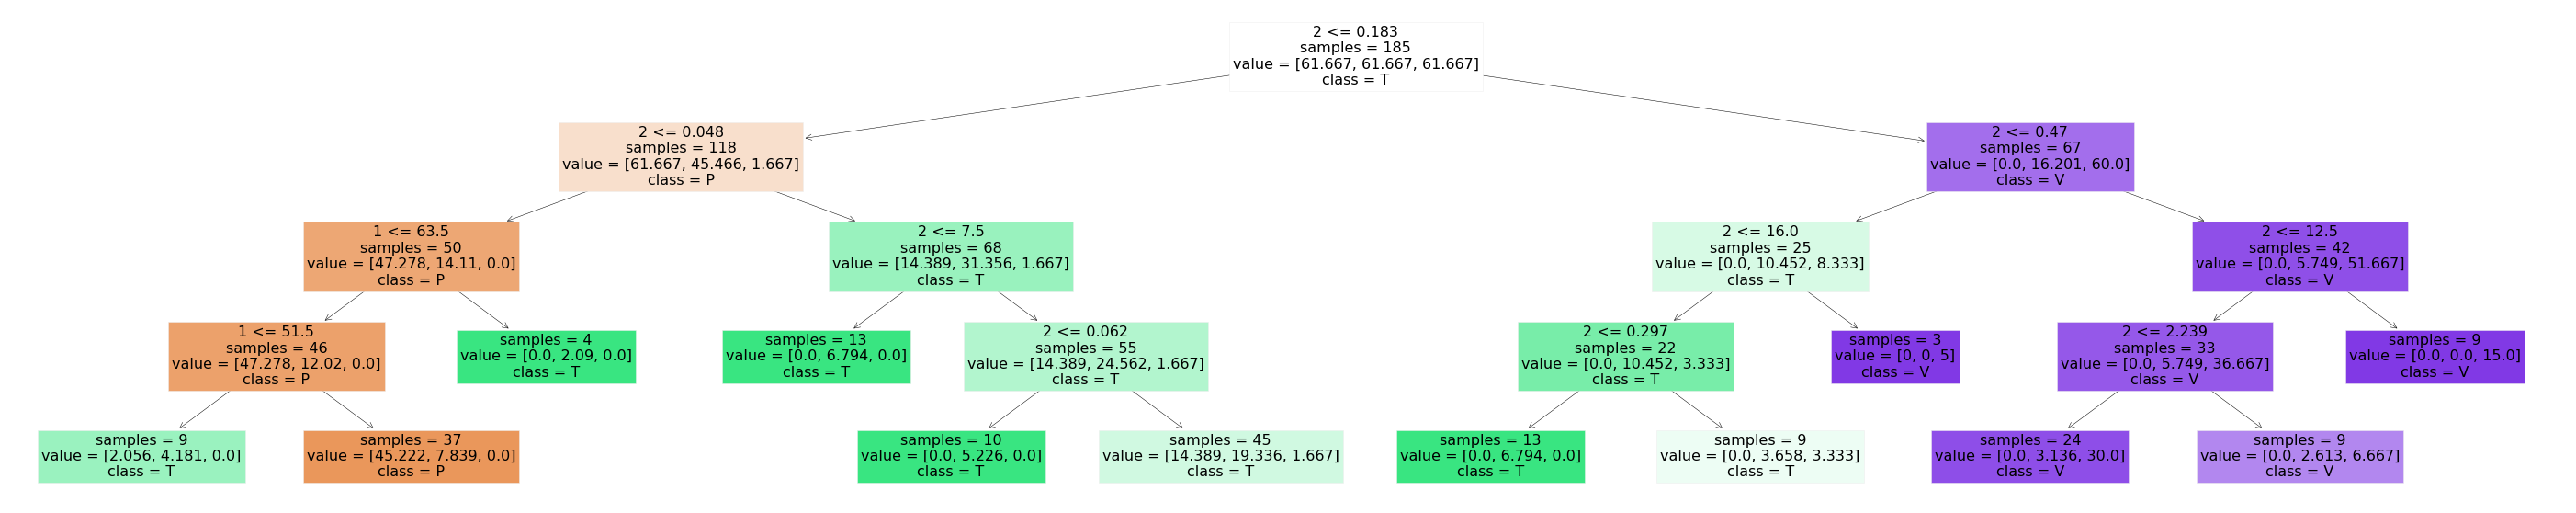

In [11]:
fig, ax = plt.subplots(figsize=(50, 10))

plot = plot_tree(
            decision_tree = dt,
            feature_names = y,
            class_names   = 'PTV-margin [mm]',
            filled        = True,
            impurity      = False,
            fontsize      = 16,
            ax            = ax
       )
plt.savefig('tree.tif', dpi=200, facecolor='white')

In [12]:
# Test error
#-------------------------------------------------------------------------------
predicciones = dt.predict(X = X_test,)

print("Confusion matrix")
print("-------------------")
confusion_matrix(
    y_true    = y_test,
    y_pred    = predicciones
)

Confusion matrix
-------------------


array([[10,  1,  0],
       [ 5, 29,  5],
       [ 0,  0, 12]])

In [13]:
accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )
print(f"Test accuracy: {100 * accuracy} %")

Test accuracy: 82.25806451612904 %


In [14]:
# Probabilities prediction
#-------------------------------------------------------------------------------
predicciones = dt.predict_proba(X = X_test)
predicciones[:10, :]

array([[0.85226527, 0.14773473, 0.        ],
       [0.40656095, 0.54634704, 0.047092  ],
       [0.        , 0.28158295, 0.71841705],
       [0.        , 1.        , 0.        ],
       [0.        , 0.09462916, 0.90537084],
       [0.85226527, 0.14773473, 0.        ],
       [0.        , 0.09462916, 0.90537084],
       [0.        , 0.        , 1.        ],
       [0.40656095, 0.54634704, 0.047092  ],
       [0.        , 0.52323232, 0.47676768]])